"""
Created on Wed Jun 19 17:45:50 2019

@author:gusmaogabriels@gmail.com // gusmaogabriels@gatech.edu

"""

## Forward and Inverse ANN ODE

Using JAX to 

   1. Reproduce the **forward-problem** results from [**Solving coupled ODEs with a neural network and autograd**](http://kitchingroup.cheme.cmu.edu/blog/category/ode/ ) (Kitchin's Group)

   * Show that the **inverse-problem** can be solved given data.
   * Demonstrate that the **inverse-problem** can be solved given **noisy** data.
   * Run a **proof of concept** for solving for the **inverse problem with latent variables** (features).

-*- coding: utf-8 -*-

#### Necessary Libraries

In [1]:
from __future__ import print_function, division, absolute_import
import jax.numpy as np
from numpy.random import choice
import numpy as onp
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.config import config
from jax.tree_util import tree_map
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools
from matplotlib import animation
from IPython.display import HTML
from IPython.display import display, Image
from matplotlib.ticker import MaxNLocator

#### Set of helper functions based on [JAX tutorials](https://colab.research.google.com/github/google/jax/blob/master/notebooks/neural_network_with_tfds_data.ipynb) ***(Google Colabs)***

*Dense Neural Network: random initialization of layers weights and biases.*

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

*Own modification of random_layer_params to generate model parameters.*

In [3]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    #w_key, b_key = random.split(key)
    #print(tuple(scale * random.normal(key, (m, 1))))
    return (scale * random.normal(key, (m,)))#, scale * random.normal(b_key, (n,))

Network and model initialization functions

In [4]:
# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [5]:
def init_model_params(size, key, scale):
 key = random.split(key,2)[-1] 
 return [random_model_params(s, key, scale) for s in size]

Universal activation function to be used. (JIT precompiled)

In [6]:
@jit
def act_fun(x):
    #return np.maximum(0, x)
    #return np.nan_to_num(x / (1.0 + np.exp(-x)))
    #return x / (1.0 + np.exp(-x))
    return 2./(1.+np.exp(-2.*x)-1.)
    #return 0.5*np.tanh(x) + 0.5*x / (1.0 + np.exp(-x))
    #return(x)

ANN evaluator for *state* variables. (JIT precompiled)

In [7]:
@jit
def state(params, t):
    # per-example stateions
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    #y = y / y.sum()
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))#, in_axes=(None, 0))

Derivatives of state variables with respect to inputs using autograd `jacfwd` for tall Jacobians. (JIT precompiled)

In [8]:
@jit
def diff_state(params,t):
        i = np.arange(len(t))
        #return (jacobian(batched_state,argnums=1)(params,t)[i,:,i,0])
        return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])

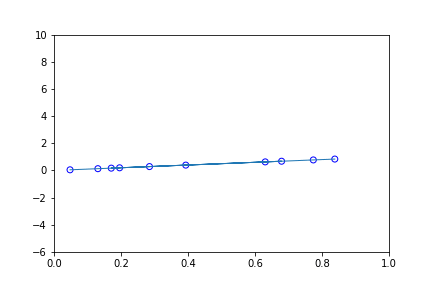

In [9]:
# based on https://www.numfys.net/howto/animations/

u = onp.random.rand(10,20)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-6, 10))
dots = ax.scatter([], [],c='',edgecolors='blue',linewidths=1.)
line, = ax.plot([], [], lw=1)

# Initialization function: plot the background of each frame
def init():
    dots.set_offsets(u[:,[0,3]])
    line.set_data(u[:,0],u[:,1])
    return line,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    dots.set_offsets( u[:,[0,i]])
    line.set_data(u[:,0],u[:,i])
    return line,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=2, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())

anim.save('filename.gif', writer='imagemagick')

from IPython.display import Image
with open('filename.gif','rb') as file:
    display(Image(file.read()))

### Kinetic Model Definitions

as in [**Solving coupled ODEs with a neural network and autograd**](http://kitchingroup.cheme.cmu.edu/blog/category/ode/ ) (Kitchin's Group)

Model parameters (rate constants): `model_params0`  
Boundary conditions (concentrations at $t=0$): `bc0`

In [10]:
model_params0 = [np.array([1.,1.])]
bc0=np.array([1.0,0.0,0.0])

/home/ggusmao3/.pyenv/versions/ML/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Model function, `x` are state variables, `t` the independet variable (e.g. time) and `model_params` packs all potential model parameters to be parsed to the function. The latter is important if they are actually changed in a different setup, e.g. solving the inverse problem, which will be shown in the next tutorial.

The model represents the following chemical reaction:

$$A\overset{k_1}{\to} B\overset{k_2}{\to} C\notag$$

Concentrations of chemical species $A$, $B$ and $C$ are observable variables, i.e. for topics [1], [2] and [3], there are not any latent (hidden) variables.

In [11]:
@jit
def model(batch, model_params):
    x, t = batch
    k,  = model_params
    return np.array([[-k[0]*x[0]],
                    [k[0]*x[0]-k[1]*x[1]],
                    [k[1]*x[1]]])

batched_model = lambda batch, model_params : vmap(model,in_axes=(0,None))(batch,model_params)[:,:,0]#, in_axes=(None, 0)

### Forward-problem numerical solution

The following numerical solution using `scipy.integrate`'s `solve_ivp` initial-value-problem solver will be used as benchmark for the NN-based equivalent solution.

In [12]:
%%time

from scipy.integrate import solve_ivp

def ode(t,C):
    return model([C,t], model_params0).flatten()

tmax = 10. # max time to evaluate
n_points = int(5*tmax) # number of points

#t_eval = np.logspace(0,np.log10(tmax),n_points)-1.
t_eval = np.logspace(0,np.log10(tmax+1),n_points)-1.
sol = solve_ivp(ode, (0, tmax), bc0, t_eval = t_eval)

CPU times: user 58.1 ms, sys: 4.44 ms, total: 62.6 ms
Wall time: 57.7 ms


#### Numerical Results

Text(0.5, 1.0, 'ODE Numerical Solution')

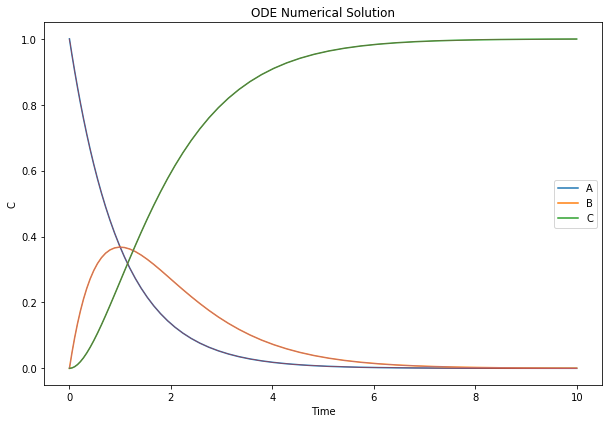

In [13]:
plt.figure(figsize=[10,10*2./3])
t = sol.t
x0 = sol.y.T
x = x0
lines = plt.plot(sol.t, x0)
plt.plot(sol.t, x,'-',ms=5,lw=0.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A', 'B', 'C'])
plt.title('ODE Numerical Solution')

## 1. Neural Net (NN) ODE ***forward*** solution

*Own development.*

Pack `t` as the generic `data` holder for the NN training.

In [14]:
t = t.reshape(-1,1)
data_fwd = [t]

#### Forward problem error function

Returns:

   `err_model`: sum of square-errors between NN derivatives with respect to inputs and those coming from the source model.   
   `err_bc`: boundary conditions.

In [15]:
def errors_fwd(params,batch):
    nn_params = params[0]
    t, = batch
    pred_x = batched_state(nn_params,t)
    err_model = (diff_state(nn_params,t)-batched_model([pred_x,t.reshape(-1,1)],model_params0))**2 
    err_bc = (batched_state(nn_params,np.array(0).reshape(-1,1))-bc0)**2
    return [err_model, err_bc]

#### Generic loss function

Returns the sum of individual errors from `get_errors`.

In [16]:
def loss(get_errors, params, batch):
    return np.array([_.mean() for _ in get_errors(params,batch)]).sum()

#### Generic training loop function

In [17]:
def train(params,data,ferrors,loss,num_epochs,num_iter,opt_objs,err_tags,batch_size=None):
    opt_state, opt_update, get_params, iter_data = opt_objs
    # Update function (JIT precompiled)
    @jit
    def step(i, opt_state, batch):
        params = get_params(opt_state)
        grads = grad(lambda errors, params, batch :np.nan_to_num(loss(ferrors, params, batch))\
                     ,argnums=1)(ferrors, params, batch)  
        return opt_update(i, grads, opt_state)
    
    itercount = itertools.count()        
    if not batch_size:
        batch_size = data[0].shape[0]
    
    iter_data += [get_params(opt_state).copy()]
    for j in range(num_epochs):
        clear_output(wait=True)
        sel = random.shuffle(random.PRNGKey(j),np.arange(data[0].shape[0])) # random shuffle
        batch = [_[:batch_size,:] for _ in data]
        for i in range(int(num_iter)):
            opt_state = step(next(itercount), opt_state , batch) 
        params = get_params(opt_state) 
        loss_it_sample = loss(ferrors, params, batch)    
        loss_it_batch = loss(ferrors, params, data)
        errs = [_.sum() for _ in ferrors(params,data)]
        print('Epoch: {:4d}, Loss Batch: {:.5e}, Loss Data: {:.5e}'.format(j,loss_it_sample,loss_it_batch)+\
                  ''.join([', Fit {}: {:.5e}'.format(_,__) for _,__ in zip(err_tags,errs)]))
        iter_data += [params.copy()]
    
    return params, [opt_state, opt_update, get_params, iter_data]

#### Forward NN intialization parameters

In [18]:
layer_sizes = [1, 8, 3] # inputs, hidden..., output layes
nn_scale = 0.01 # weights scales
key = random.PRNGKey(0)
nn_params = init_network_params(layer_sizes, key, nn_scale) # initialize parameters

#### Forward training settings

In [19]:
num_epochs = 200
num_iter = 200
batch_size = n_points
model_params = model_params0

**Initialize Optimization Objects**

In [20]:
opt_objs = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-10)
opt_objs = (opt_objs[0]([nn_params, []]), opt_objs[1], opt_objs[2], [])

#### Forward problem training loop call

In [21]:
%%time
params = [nn_params, []]
err_tags = ['Model','BC']
[params, opt_objs] = train(params,data_fwd,errors_fwd,loss,num_epochs,num_iter,opt_objs,err_tags,batch_size=None)
nn_params, model_params = params

Epoch:  199, Loss Batch: 1.82051e-06, Loss Data: 1.82051e-06, Fit Model: 2.66362e-04, Fit BC: 1.34270e-07
CPU times: user 50.5 s, sys: 1.84 s, total: 52.3 s
Wall time: 46.6 s


### Forward ANN ODE results

As shown below, the results from the NN with only 6 hidden neurons are almost identical to those from the numerical method, although taking almost $10^4$ times longer for this small problem. Scalability has not yet been appraised for larger problems. It could be the case that the ANN might scale better than standard numerical iterative methods. 

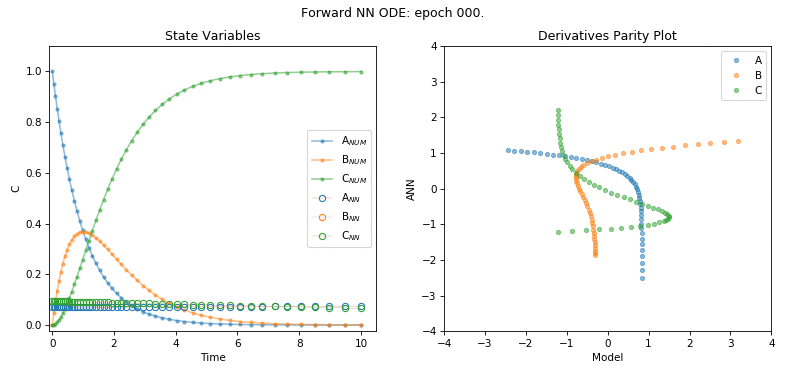

In [22]:
fig, axs = plt.subplots(1,2,figsize=[10.5,10*1./2],dpi=75)
axs = axs.tolist()
plt.sca(axs[0])
lines1 = plt.plot(sol.t, x0,'-o',alpha=0.5,ms=3)
lines2 = [plt.plot([],[],'-o',lw=0.2,\
                  ms=6,markerfacecolor='None',markeredgecolor='black')[0] for _ in range(3)]
for _1,_2 in zip(lines1,lines2):
    _2.set_markeredgecolor(_1.get_markeredgecolor())

leg1 = plt.legend(iter(lines1+lines2), ['A$_{NUM}$', 'B$_{NUM}$', 'C$_{NUM}$','A$_{NN}$','B$_{NN}$','C$_{NN}$'],loc=7)
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.sca(axs[1])
x_parity = batched_model([x,t],model_params0)
y_parity = batched_model([batched_state(nn_params,t),t],model_params0)
x_parity, y_parity = [(_-_.mean(axis=0))/_.std(axis=0) for _ in [x_parity, y_parity]]
linesp = [plt.plot([],[],'o',lw=0.2,ms=4,alpha=0.5)[0] for _ in range(3)]
leg2 = plt.legend(['A','B','C'])
plt.title('Derivatives Parity Plot')
plt.xlabel('Model')
plt.ylabel('ANN');
title = fig.suptitle('')
plt.tight_layout(rect=[0.,0.,1.,0.95])

epochs = [0,1,2]
while epochs[-1]<len(opt_objs[-1])-1:
    epochs += [int((epochs[-1]+1)**1.05)]
epochs[-1] = len(opt_objs[-1])-1
pack = list(zip(epochs,[opt_objs[-1][int(_)][0] for _ in epochs]))

def init():
    axs[0].set_ylim([-0.025,1.1])
    axs[0].set_xlim([-0.1,10.5])
    axs[1].set_ylim([-4,4])
    axs[1].set_xlim([-4,4])
    return lines2+linesp#+axs

def animate(i):
    epoch, nn_params = pack[i]
    title.set_text('Forward NN ODE: epoch {:03d}.'.format(int(epoch)))
    d = batched_state(nn_params, t)
    for _ in range(d.shape[1]):
        lines2[_].set_data(t,d[:,_])
    y_parity = batched_model([batched_state(nn_params,t),t],model_params0)
    y_parity = (y_parity-y_parity.mean(axis=0))/y_parity.std(axis=0)
    for _ in range(y_parity.shape[1]):
        linesp[_].set_data(x_parity[:,_],y_parity[:,_])
    #dots.set_offsets( u[:,[0,i]])
    #line.set_data(u[:,0],u[:,i])
    return lines2+linesp#+axs

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(epochs), interval=250, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())

anim.save('intro.gif', writer='imagemagick')

from IPython.display import Image
with open('intro.gif','rb') as file:
    display(Image(file.read()))

## 2. Neural Net (NN) ODE *inverse* solution

*Own development.*

Let's change the error function to be in terms of fitting to data, `err_data` and fitting to model, `err_model`. Boundary conditions are not necessary, since we will be fittin the whole problem based on generated data and unkown parameters.

In [23]:
def errors_inv(params,batch):
    x, t = batch
    nn_params, model_params = params
    pred_x = batched_state(nn_params,t)
    err_data = ((pred_x-x)**2).sum(axis=1)
    err_model = ((diff_state(nn_params,t)-batched_model([pred_x,t],model_params))**2 ).sum(axis=1)
    return [err_data, err_model]

`data` is a list of time and data generated above in the numerical solution for the forward problem.

In [24]:
data_inv = (x,t)

#### Inverse NN intialization parameters
The neural net weights and model parameters are packed in a single list to be parsed as generic training weights for the `adam` optimizer.

In [25]:
layer_sizes = [1, 8, 3] # inputs, hidden..., output layes
model_size = [len(model_params0[0])]

nn_scale = 0.01 # weights scales
model_scale = 0.0001 # model scale (assume low so as not to eb bias)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack

#### Inverse training settings

In [26]:
num_epochs = 100
num_iter = 100
batch_size = n_points

**Initalize Optimization Objects**

In [27]:
opt_inv = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
opt_inv = (opt_inv[0](params), opt_inv[1], opt_inv[2], [])

#### Inverse problem training loop call

In [28]:
%%time
err_tags = ['Data','Model']
params = train(params,data_inv,errors_inv,loss,num_epochs,num_iter,opt_inv,err_tags,batch_size=None)
[params, opt_inv] = params
nn_params_inv, model_params_inv = params

Epoch:   99, Loss Batch: 1.39389e-05, Loss Data: 1.39389e-05, Fit Data: 2.19966e-04, Fit Model: 4.76978e-04
CPU times: user 15.6 s, sys: 636 ms, total: 16.3 s
Wall time: 14.3 s


### Inverse ANN ODE results

This is neat. For linear problems with respect to parameters, the latter can be trained along with a NN and the results are pretty accurate given the low number of training epochs a priori defined.

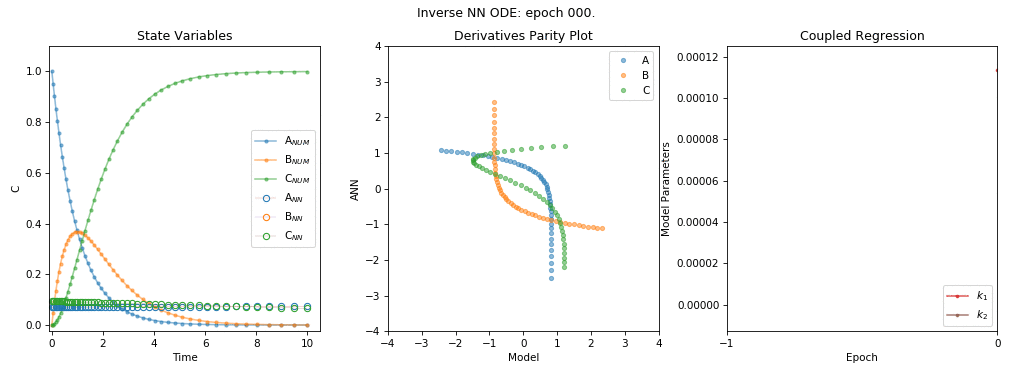

True parameters:      ['1.00000', '1.00000']
Regressed parameters: ['1.00056', '0.99958']


In [29]:
fig, axs = plt.subplots(1,3,figsize=[13.5,10*1./2],dpi=75)
axs = axs.tolist()
plt.sca(axs[0])
lines1 = plt.plot(sol.t, x0,'-o',alpha=0.5,ms=3)
lines2 = [plt.plot([],[],'-o',lw=0.2,\
                  ms=6,markerfacecolor='None',markeredgecolor='black')[0] for _ in range(3)]
for _1,_2 in zip(lines1,lines2):
    _2.set_markeredgecolor(_1.get_markeredgecolor())

leg1 = plt.legend(iter(lines1+lines2), ['A$_{NUM}$', 'B$_{NUM}$', 'C$_{NUM}$','A$_{NN}$','B$_{NN}$','C$_{NN}$'],loc=7)
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.sca(axs[1])
linesp = [plt.plot([],[],'o',lw=0.2,ms=4,alpha=0.5)[0] for _ in range(3)]
leg2 = plt.legend(['A','B','C'])
plt.title('Derivatives Parity Plot')
plt.xlabel('Model')
plt.ylabel('ANN');
plt.sca(axs[2])
plt.title('Coupled Regression')
plt.xlabel('Epoch')
plt.ylabel('Model Parameters')
lines3 = [plt.plot([], [],'.-',alpha=0.75,ms=5)[0] for _ in range(2)]
c = ['#d62728','#8c564b']
for _ in range(len(lines3)):
    lines3[_].set_color(c[_])
plt.plot([0,200],[1,1],'-',lw=0.5,alpha=0.2,color='blue')
plt.legend(iter(lines3), ['$k_1$','$k_2$'],loc=4)
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))

title = fig.suptitle('')
plt.tight_layout(rect=[0.,0.,1.,0.95])

epochs = [0,1,2]
while epochs[-1]<len(opt_inv[-1])-1:
    epochs += [int((epochs[-1]+1)**1.03)]
epochs[-1] = len(opt_inv[-1])-1
pack = list(zip(epochs,[opt_inv[-1][int(_)] for _ in epochs]))

def init():
    axs[0].set_ylim([-0.025,1.1])
    axs[0].set_xlim([-0.1,10.5])
    axs[1].set_ylim([-4,4])
    axs[1].set_xlim([-4,4])
    return lines2+linesp+lines3#+axs

def animate(i):
    epoch, params = pack[i]
    nn_params, model_params = params
    title.set_text('Inverse NN ODE: epoch {:03d}.'.format(int(epoch)))
    d = batched_state(nn_params, t)
    for _ in range(d.shape[1]):
        lines2[_].set_data(t,d[:,_])
    x_parity = batched_model([x,t],model_params)
    y_parity = batched_model([batched_state(nn_params,t),t],model_params)
    x_parity, y_parity = [(_-_.mean(axis=0))/_.std(axis=0) for _ in [x_parity, y_parity]]
    for _ in range(y_parity.shape[1]):
        linesp[_].set_data(x_parity[:,_],y_parity[:,_])
    for _ in range(2):
        lines3[_].set_data(np.arange(0,epoch+1).tolist(),[opt_inv[-1][p][-1][0][_] for p in np.arange(0,epoch+1)])
    axs[2].set_xlim([-1,epoch])
    axs[2].set_ylim([0.9*np.min([np.min(_.get_data()[1]) for _ in lines3]),
                     1.1*np.max([np.max(_.get_data()[1]) for _ in lines3])])
    #dots.set_offsets( u[:,[0,i]])
    #line.set_data(u[:,0],u[:,i])
    return lines2+linesp+lines3#+axs

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(epochs), interval=250, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())

anim.save('non_noise.gif', writer='imagemagick')

from IPython.display import Image
with open('non_noise.gif','rb') as file:
    display(Image(file.read()))
    
print('True parameters:      {}'.format(['{:.5f}'.format(float(_)) for _ in model_params0[0]]))
print('Regressed parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params_inv[0]]))


## 3. Neural Net (NN) ODE *inverse* solution given NOISY data

*Own development.*

Let's add some white noise to data.

In [51]:
data_inv_noisy = (x+random.normal(key,x.shape)*0.05,t)

#### Inverse NN intialization parameters given noisy data

In [52]:
layer_sizes = [1, 10, 3] # inputs, hidden..., output layes
model_size = [len(model_params0[0])]

nn_scale = 0.01 # weights scales
model_scale = 0.0001 # model scale (assume low so as not to eb bias)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack

#### Inverse training settings given noisy data

In [53]:
num_epochs = 100
num_iter = 100
batch_size = n_points

**Initialize Optimization Objects**

In [54]:
opt_inv_noisy = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-10)
opt_inv_noisy = (opt_inv_noisy[0](params), opt_inv_noisy[1], opt_inv_noisy[2], [])

#### Inverse problem training loop call given noisy data

In [55]:
%%time
err_tags = ['Data','Model']
params = train(params,data_inv_noisy,errors_inv,loss,num_epochs,num_iter,opt_inv_noisy,err_tags,batch_size=None)
[params, opt_inv_noisy] = params
nn_params_inv_noisy, model_params_noisy = params

Epoch:   99, Loss Batch: 7.86787e-03, Loss Data: 7.86787e-03, Fit Data: 3.88680e-01, Fit Model: 4.71333e-03
CPU times: user 16.5 s, sys: 558 ms, total: 17 s
Wall time: 15.3 s


### Inverse ANN ODE results

The noisy-data results have really impressed me. I was not expecting such tight regression without adding extra-time as compared both to solving the forward and the noise-free inverse problem.

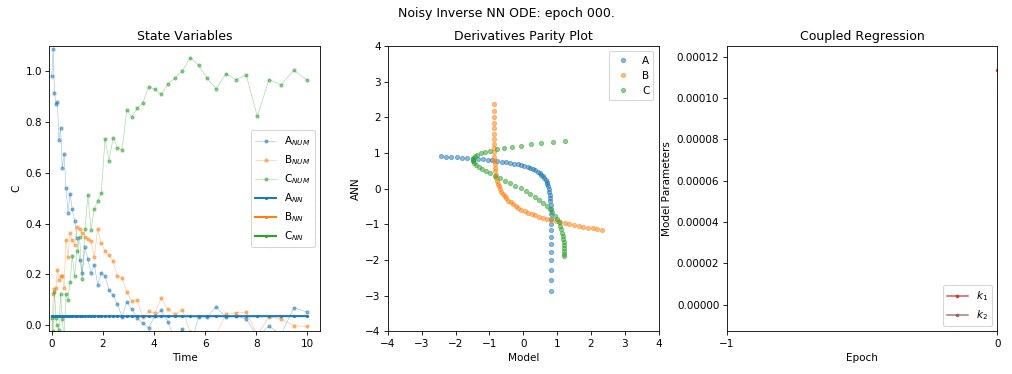

True parameters: ['1.00000', '1.00000']
Regressed parameters: ['1.00967', '1.00224']


In [56]:
fig, axs = plt.subplots(1,3,figsize=[13.5,10*1./2],dpi=75)
axs = axs.tolist()
plt.sca(axs[0])
lines1 = plt.plot(sol.t, data_inv_noisy[0],'-o',alpha=0.5,ms=3,lw=0.5)
lines2 = [plt.plot([],[],'.-',lw=2.,\
                  ms=4,markerfacecolor='None',markeredgecolor='black')[0] for _ in range(3)]
for _1,_2 in zip(lines1,lines2):
    _2.set_markeredgecolor(_1.get_markeredgecolor())
    _2.set_color(_1.get_markeredgecolor())

leg1 = plt.legend(iter(lines1+lines2), ['A$_{NUM}$', 'B$_{NUM}$', 'C$_{NUM}$','A$_{NN}$','B$_{NN}$','C$_{NN}$'],loc=7)
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.sca(axs[1])
linesp = [plt.plot([],[],'o',lw=0.2,ms=4,alpha=0.5)[0] for _ in range(3)]
leg2 = plt.legend(['A','B','C'])
plt.title('Derivatives Parity Plot')
plt.xlabel('Model')
plt.ylabel('ANN');
plt.sca(axs[2])
plt.title('Coupled Regression')
plt.xlabel('Epoch')
plt.ylabel('Model Parameters')
lines3 = [plt.plot([], [],'.-',alpha=0.75,ms=5)[0] for _ in range(2)]
c = ['#d62728','#8c564b']
for _ in range(len(lines3)):
    lines3[_].set_color(c[_])
plt.plot([0,200],[1,1],'-',lw=0.5,alpha=0.2,color='blue')
plt.legend(iter(lines3), ['$k_1$','$k_2$'],loc=4)
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))

title = fig.suptitle('')
plt.tight_layout(rect=[0.,0.,1.,0.95])

epochs = [0,1,2]
while epochs[-1]<len(opt_inv_noisy[-1])-1:
    epochs += [int((epochs[-1]+1)**1.05)]
epochs[-1] = len(opt_inv_noisy[-1])-1
pack = list(zip(epochs,[opt_inv_noisy[-1][int(_)] for _ in epochs]))

def init():
    axs[0].set_ylim([-0.025,1.1])
    axs[0].set_xlim([-0.1,10.5])
    axs[1].set_ylim([-4,4])
    axs[1].set_xlim([-4,4])
    return lines2+linesp+lines3#+axs

def animate(i):
    epoch, params = pack[i]
    nn_params, model_params = params
    title.set_text('Noisy Inverse NN ODE: epoch {:03d}.'.format(int(epoch)))
    d = batched_state(nn_params, t)
    for _ in range(d.shape[1]):
        lines2[_].set_data(t,d[:,_])
    x_parity = batched_model([x,t],model_params)
    y_parity = batched_model([batched_state(nn_params,t),t],model_params)
    x_parity, y_parity = [(_-_.mean(axis=0))/_.std(axis=0) for _ in [x_parity, y_parity]]
    for _ in range(y_parity.shape[1]):
        linesp[_].set_data(x_parity[:,_],y_parity[:,_])
    for _ in range(2):
        lines3[_].set_data(np.arange(0,epoch+1).tolist(),[opt_inv_noisy[-1][p][-1][0][_] for p in np.arange(0,epoch+1)])
    axs[2].set_xlim([-1,epoch])
    axs[2].set_ylim([0.9*np.min([np.min(_.get_data()[1]) for _ in lines3]),
                     1.1*np.max([np.max(_.get_data()[1]) for _ in lines3])])
    #dots.set_offsets( u[:,[0,i]])
    #line.set_data(u[:,0],u[:,i])
    return lines2+linesp+lines3#+axs

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(epochs), interval=250, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())

anim.save('noisy.gif', writer='imagemagick')

from IPython.display import Image
with open('noisy.gif','rb') as file:
    display(Image(file.read()))

print('True parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params0[0]]))
print('Regressed parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params_noisy[0]]))


## 4. Neural Net (NN) ODE *inverse* solution - Latent Variables

*Own development.*

The problem now relates to the field of heterogeneous catalysts, in which chemical reactions take place on the surface of catalysts and, therefore, there is a certain fraction of chemical species that are not observable for they are either on the catalyst or have there broken down or merged into other species that cannot be observed. The process of migrating from the observable space (e.g. bulk gas or liquid phases) to a catalyst surface is called adsorption, and the reverse process desorption. Species on the 'non-observable' catalyst surface are referred to as adsorbed species and are hereafter distiguinshed by asterisk marks, in the same way 'free-sites'are labeled.  

The proposed kinetic model is completely reversible as follows:

$$A+*\overset{k_1}{\underset{k_2}\rightleftharpoons} A* $$
$$B+*\overset{k_3}{\underset{k_4}\rightleftharpoons} B* $$
$$C+*\overset{k_5}{\underset{k_6}\rightleftharpoons} C* $$
$$2A*\overset{k_7}{\underset{k_8}\rightleftharpoons} B*+* $$
$$B*+*\overset{k_9}{\underset{k_{10}}\rightleftharpoons} 2C* $$

The three first reaction describe the adsorption/desorption steps of species $A$, $B$ and $C$ and the remaining two are the surface transformation of $A$ to $B$ and $B$ to $C$ in this order. There a total of 10 parameters, $k_i$ for $i=1,2,...,10$, which are going to be arbitrarily defined and further inferred as the inverse problem is solved.

#### Boundary Condition

When it comes heterogeneous models, boundary conditions are necessary for both observable and non-observable phases, the latter of which is initially assumed from prior knowledge on the system under scrutiny. In addition to those, a total mass balance is included, since the system is assumed to be closed and, hence, total mass is conserved. Adsorbed species are treated in terms of fractional coverage, i.e. a fraction of a total number of catalytic sites, and are therefore normalized and a total number of catalytic sites is assumed.

In [36]:
model_params_latent0 = [np.array([.1,.2,.25,.15,.125,.15,3.25,2.125,3.175,1.525])] # model parameters
n_latent = 4 # number of latent variables
nt = 1. # total number of catalytic sites
mw = np.array([1.,1.,1.,1.,1.,1.,0.]) # molar weight of species
bc = np.array([1.,2.,3.,0.,0.,0.,1.]) # boundary conditions [A,B,C,A*,B*,C*,*]; A, B and C in quantity, others as fractional coverage. 
mw_w = mw*np.array([1.]*(len(bc)-n_latent)+[nt]*n_latent) # molar weight of species

#### Latent Variables Model

In [37]:
@jit
def model_latent(batch, model_params):
    x, t = batch
    k,  = model_params
    k, x = [np.abs(_) for _ in [k,x]]
    return np.array([[(-k[0]*x[0]*x[6]+k[1]*x[3])*nt],
                    [(-k[2]*x[1]*x[6]+k[3]*x[4])*nt],
                    [(-k[4]*x[2]*x[6]+k[5]*x[5])*nt],
                    [(k[0]*x[0]*x[6]-k[1]*x[3]-1*k[6]*x[3]**1+1*k[7]*x[4]*x[6])],
                    [(k[2]*x[1]*x[6]-k[3]*x[4]+k[6]*x[3]**1-k[7]*x[4]*x[6]-k[8]*x[4]*x[6]+k[9]*x[5]**1)],
                    [(k[4]*x[2]*x[6]-k[5]*x[5]+1*k[8]*x[4]*x[6]-1*k[9]*x[5]**1)],
                    [(-k[0]*x[0]*x[6]+k[1]*x[3]-k[2]*x[1]*x[6]+k[3]*x[4]-k[4]*x[2]*x[6]+k[5]*x[5]\
                     +k[6]*x[3]**1-k[7]*x[4]*x[6]-k[8]*x[4]*x[6]+k[9]*x[5]**1)]])

batched_model_latent = lambda batch, model_params : \
                        vmap(model_latent,in_axes=(0,None))(batch,model_params)[:,:,0]#, in_axes=(None, 0)

### Forward latent problem numerical solution

In [38]:
%%time

def ode_latent(t,C):
    return model_latent([C,t], model_params_latent0).flatten()

tmax_latent =200.# max time to evaluate
n_points_latent_log = 20
n_points_latent_linear = 35
alpha = 0.1

t_eval_latent = np.logspace(0,np.log10(tmax_latent+1),int(n_points_latent_log))-1.

#t_eval_latent = np.concatenate((np.logspace(0,np.log10(tmax_latent*alpha+1),int(n_points_latent_log))-1.,\
#                                np.linspace(tmax_latent*alpha+1e-3,tmax_latent,int(n_points_latent_linear))))
#t_eval_latent = np.linspace(0,tmax_latent,n_points_latent)
sol_latent = solve_ivp(ode_latent, (0, tmax_latent), bc, t_eval = t_eval_latent)

CPU times: user 1.41 s, sys: 82.8 ms, total: 1.49 s
Wall time: 1.35 s


#### Numerical Results

Text(0.5, 1.0, 'ODE Numerical Solution - Latent Variables')

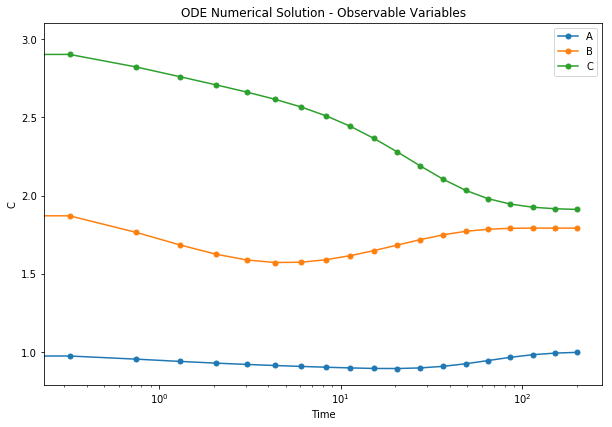

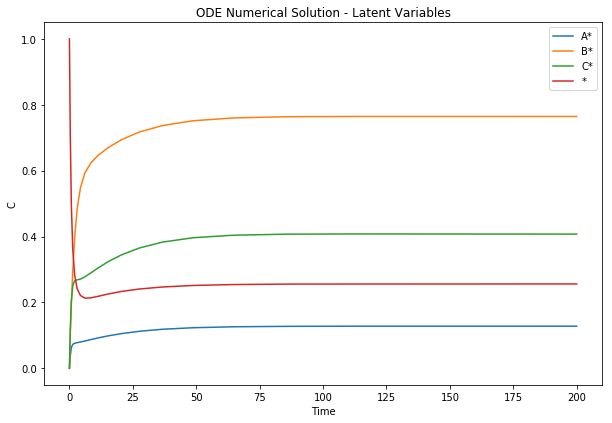

In [39]:
plt.figure(figsize=[10,10*2./3])
t_latent = sol_latent.t
x0_latent = sol_latent.y.T
x_latent = x0_latent
lines = plt.plot(t_latent, x_latent[:,:n_latent-1],'-o',ms=5,lw=1.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A', 'B', 'C'])
plt.title('ODE Numerical Solution - Observable Variables')
plt.gca().set_xscale('log')
plt.figure(figsize=[10,10*2./3])
t_latent = (sol_latent.t).reshape(-1,1)
x0_latent = sol_latent.y.T
x_latent = x0_latent
lines = plt.plot(t_latent, x_latent[:,-n_latent:],'-',ms=5,lw=1.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A*', 'B*', 'C*', '*'])
plt.title('ODE Numerical Solution - Latent Variables')

Pack the data.

In [40]:
data_latent = (x_latent[:,:n_latent-1],t_latent)

#### Errors

The cost function will be determined by a composition of errors, namely: boundary condition erro for the non-observable phase phase, `err_bc`, total mass balance erro, `err_mb`, NN to data error, `err_data`, NN to model error, `err_model` and a normalization term for the latent variables, `err_norm`.

In [41]:
def relative_error(series):
    return series.sum(axis=1)#*(1.+series.var(axis=1))

In [42]:
def errors_latent(params,batch):
    x, t = batch
    nn_params, model_params = params
    pred_x = np.abs(batched_state(nn_params,t))
    pred_x0 = np.abs(batched_state(nn_params,np.array([[0.]])))
    err_data = relative_error((pred_x[:,:n_latent-1]-x)**2)
    err_model = relative_error((diff_state(nn_params,t)[:,:n_latent-1]-\
                                batched_model_latent([pred_x,t],model_params)[:,:n_latent-1])**2)+ \
                relative_error((diff_state(nn_params,t)[:,-n_latent:]-\
                                batched_model_latent([pred_x,t],model_params)[:,-n_latent:])**2)
    err_bc = relative_error((pred_x0[:,-n_latent:]-bc[-n_latent:])**2)
    err_mb = (((pred_x*mw_w).sum(axis=1)-(pred_x0*mw_w).sum(axis=1))**2)
               #(((pred_x*mw_w).sum(axis=1)-(bc*mw_w).reshape(1,-1).sum(axis=1))**2)
               #(((pred_x*mw_w).sum(axis=1)-(batched_state(nn_params,np.array([[0.]]))*mw_w).sum(axis=1))**2).mean()
    barrier = 1e-4
    err_norm =  (pred_x[:,-n_latent:].sum(axis=1)-1.)**2 
                #barrier**2*np.exp((1.-pred_x[:,-n_latent:]/barrier)).sum()+\
                #barrier**2*np.exp((-model_params[0]/barrier)).sum()+\
    return [err_data, 1e-2*err_model, 1e-6*err_bc, 1e-6*err_mb, 1e-6*err_norm]

#### Inverse NN intialization parameters for the latent-variables model

#### Inverse training settings for the latent-variables model

In [43]:
num_epochs = 100
num_iter = 100
batch_size = None

**Initialize Optimization Objects**

In [44]:
opt_latent = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
opt_latent = (opt_latent[0](params), opt_latent[1], opt_latent[2])

#### Inverse problem training loop call for the latent-variables model

In [45]:
%%time
err_tags = ['Data','Model','BC','MB','norm']
for _ in range(100000):
    [params, opt_latent] = train(params,data_latent,errors_latent,loss,num_epochs,num_iter\
                                 ,opt_latent,err_tags,batch_size)
    nn_params_latent, model_params_latent = params

ValueError: not enough values to unpack (expected 4, got 3)

### Inverse ANN ODE results (Latent Variables)

The noisy-data results have really impressed me. I was not expecting such tight regression without adding extra-time as compared both to solving the forward and the noise-free inverse problem.

NameError: name 'nn_params_latent' is not defined

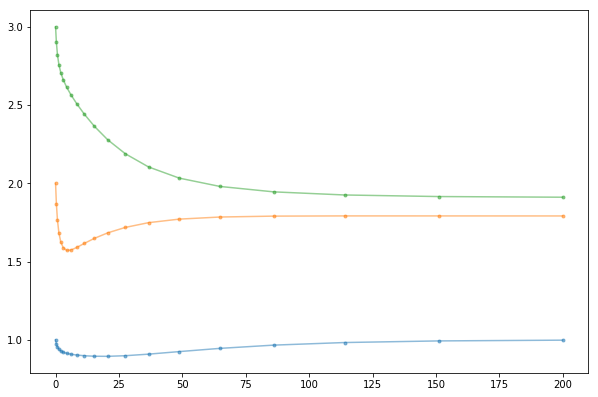

In [46]:
plt.figure(figsize=[10,10*2./3])
lines1a = plt.plot(t_latent, x_latent[:,:n_latent-1],'-o',alpha=0.5,ms=3)
lines2a = plt.plot(t_latent,np.abs(batched_state(nn_params_latent, t_latent)[:,:-n_latent]),'-o',lw=0.2,\
                  ms=6,markerfacecolor='None',markeredgecolor='black')
for _1,_2 in zip(lines1a,lines2a):
    _2.set_markeredgecolor(_1.get_markeredgecolor())
plt.legend(iter(lines1a+lines2a), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Observable State Variables')
plt.xlabel('Time')
plt.ylabel('C');
#plt.gca().set_xscale('log')
plt.figure(figsize=[10,10*2./3])
lines1b = plt.plot(t_latent, x_latent[:,-n_latent:],'-o',alpha=0.5,ms=3)
lines2b = plt.plot(t_latent,np.abs(batched_state(nn_params_latent, t_latent)[:,-n_latent:]),'-o',lw=0.2,\
                  ms=6,markerfacecolor='None',markeredgecolor='black')
for _1,_2 in zip(lines1b,lines2b):
    _2.set_markeredgecolor(_1.get_markeredgecolor())
plt.legend(iter(lines1b+lines2b), ['A*', 'B*', 'C*','*','A*$_{NN}$','B*$_{NN}$','C*$_{NN}$','*$_{NN}$'])
plt.title('Latent Variables Variables')
plt.xlabel('Time')
plt.ylabel('C');
#plt.gca().set_xscale('log')
plt.figure(figsize=[10,10*2./3])
plt.plot(batched_model([x_latent,t_latent],model_params_latent0),\
         batched_model([batched_state(nn_params_latent,t_latent),t_latent],model_params_latent),\
         'o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Derivatives Parity Plot - Noisy Data')
plt.xlabel('Model')
plt.ylabel('ANN');

print('True parameters:      {}'.format(['{:.3f}'.format(float(_)) for _ in model_params_latent0[0]]))
print('Regressed parameters: {}'.format(['{:.3f}'.format(np.abs(float(_))) for _ in model_params_latent[0]]))